In [ ]:
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('tox21_chembert.csv')

In [ ]:
# data = pd.read_csv('tox21_dataset.csv')

# **Three Features**

In [ ]:
TOX21_TASKS = ['NR-AR', 'NR-AR-LBD', 'NR-AhR']
task_data = data.iloc[:, 0:3]
feature_data = data.iloc[:, 14:]

In [ ]:
# normalize data
scaler = StandardScaler()
feature_data_normal = scaler.fit_transform(feature_data)

In [ ]:
from joblib import dump, load
dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
task_data.shape

(7831, 3)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification


# define dataset
feature_data_normal, _ = make_classification(n_samples=7831, n_features=384, n_informative=384, n_redundant=0,  random_state=42, n_classes=12)
# summarize the dataset
print(feature_data_normal)



new_dimensionality = 2

lda = LinearDiscriminantAnalysis(n_components=new_dimensionality)
feature_data_lda = lda.fit_transform(feature_data_normal, task_data)

[[ -4.58342188  -4.43847446   2.41117809 ...  -7.71318592  -2.26005178
   -3.39069024]
 [ -4.42705118  12.81672179 -12.51051129 ... -17.89261584  -5.18541557
   12.17154592]
 [  9.59674884  18.12554395  -7.24697504 ...  -5.62874309   9.11800379
  -14.88955003]
 ...
 [  2.30504101  26.13622585   5.81041213 ...   8.51164325   8.75438421
  -16.48749464]
 [ 18.01512421 -10.39224536   0.54876644 ... -27.92148542   9.51172273
   -4.44936847]
 [  8.04511183   5.12481794  -1.63911003 ...   0.26397166  -3.18511005
  -11.54296428]]


ValueError: y should be a 1d array, got an array of shape (7831, 3) instead.

In [ ]:
#split the data into training and test data
features_train, features_test, task_train, task_test = train_test_split(feature_data_normal, task_data, test_size=0.20)

print(task_train.shape)
print(features_train.shape)

(6264, 3)
(6264, 384)


In [ ]:
task_train.value_counts()

NR-AR  NR-AR-LBD  NR-AhR
0      0          0         5375
                  1          568
1      1          0          115
       0          0          106
0      1          0           56
1      0          1           29
0      1          1           13
1      1          1            2
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# Adjust k_neighbors for SMOTE and n_neighbors for ENN
# smote = SMOTE(k_neighbors=5, random_state=42)  # This can be added for hyperparameter tuning
enn = EditedNearestNeighbours(n_neighbors=3)    # This can be added for hyperparameter tuning
# Initialize SMOTEENN with a fixed random state for reproducibility (add smote and enn if need be)
smote_enn = SMOTEENN(random_state=42)
# Resample ONLY the training data
features_train, task_train = smote_enn.fit_resample(features_train, task_train)

ValueError: Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.

In [ ]:
task_train.value_counts()

NR-AR  NR-AR-LBD  NR-AhR
0      0          0         5375
                  1          568
1      1          0          115
       0          0          106
0      1          0           56
1      0          1           29
0      1          1           13
1      1          1            2
Name: count, dtype: int64

In [ ]:
def calculate_class_weights_for_columns(y_columns):
    class_weights_dict = {}

    for col_idx in range(y_columns.shape[1]):
        column = y_columns.iloc[:, col_idx]
        unique_classes, class_counts = np.unique(column, return_counts=True)
        total_samples = len(column)
        class_weights = {}

        for class_label, class_count in zip(unique_classes, class_counts):
            class_weight = total_samples / (2.0 * class_count)
            class_weights[class_label] = class_weight

        class_weights_dict[col_idx] = class_weights

    return class_weights_dict

class_weights = calculate_class_weights_for_columns(task_train)
print("Class weights per column:", class_weights)

Class weights per column: {0: {0: 0.5209580838323353, 1: 12.428571428571429}, 1: {0: 0.5153010858835143, 1: 16.838709677419356}, 2: {0: 0.554140127388535, 1: 5.117647058823529}}


In [ ]:
sample_weights = []
for index, task in enumerate(task_train):
  cw_dict = class_weights[index]
  off_cw = cw_dict[0]
  on_cw = cw_dict[1]

  # print(off_cw, on_cw)
  task_weight = []
  # print(task)
  for x, item in enumerate(task_train[task]):
    if item == 0:
      task_weight.append(off_cw)
    if item == 1:
      task_weight.append(on_cw)

  sample_weights.append(task_weight)

print(sample_weights)
print(len(sample_weights)) # = np.array(sample_weight).T
print(len(sample_weights[0]), len(sample_weights[1]), len(sample_weights[2]))

[[0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353, 0.5209580838323353

In [ ]:
features_train = np.array(features_train)

NR_AR_array = np.array(task_train.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_train.iloc[:,1:2])
NR_AhR_array = np.array(task_train.iloc[:,2:3])

In [ ]:
NR_AR_weights = np.array(sample_weights[0])
NR_AR_LBD_weights = np.array(sample_weights[1])
NR_AhR_weights = np.array(sample_weights[2])

In [ ]:
import tensorflow as tf
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = alpha * (1 - p_t) ** gamma * bce
        return loss
    return loss

In [ ]:
def build_model(features):

  #input layer
  xin = tf.keras.layers.Input((features.shape[1],))

  # Add a normalizer layer
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(features_train)

  xin = normalizer(xin)

  #hidden layers
  x1 = tf.keras.layers.Dense(32, activation='relu')(xin)
  x1 = tf.keras.layers.Dropout(0.42)(x1)

  outputs = list()
  for _task in TOX21_TASKS:
    outputs.append(tf.keras.layers.Dense(1, activation='sigmoid', name=_task)(x1))

  return tf.keras.models.Model(inputs = xin, outputs = outputs)


In [ ]:
myModel = build_model(features_train)

In [ ]:

myModel.compile(loss = [focal_loss(alpha=0.25, gamma=2.0)]*len(TOX21_TASKS),
                metrics=[["accuracy", "precision", "f1_score", "recall"]]*len(TOX21_TASKS),
                optimizer=Adam(learning_rate=0.007))


In [ ]:
myModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE       │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         12,320 │ keras_tensor_1CLONE[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR (Dense)             │ (None, 1)              │             33 │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR-LBD (Dense)         │ (None, 1)              │             33 │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AhR (Dense)            │ (None, 1)              │             33 │ dropout[1][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,419 (48.51 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = myModel.fit(features_train,
                    [NR_AR_array, NR_AR_LBD_array, NR_AhR_array],
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2,
                    sample_weight = [NR_AR_weights, NR_AR_LBD_weights, NR_AhR_weights])

Epoch 1/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - NR-AR-LBD_accuracy: 0.8964 - NR-AR-LBD_f1_score: 0.0549 - NR-AR-LBD_loss: 0.0261 - NR-AR-LBD_precision: 0.1402 - NR-AR-LBD_recall: 0.4820 - NR-AR_accuracy: 0.8665 - NR-AR_f1_score: 0.0800 - NR-AR_loss: 0.0380 - NR-AR_precision: 0.1348 - NR-AR_recall: 0.3212 - NR-AhR_accuracy: 0.7855 - NR-AhR_f1_score: 0.1835 - NR-AhR_loss: 0.0551 - NR-AhR_precision: 0.1496 - NR-AhR_recall: 0.2332 - loss: 0.1192 - val_NR-AR-LBD_accuracy: 0.9617 - val_NR-AR-LBD_f1_score: 0.0619 - val_NR-AR-LBD_loss: 0.0163 - val_NR-AR-LBD_precision: 0.3889 - val_NR-AR-LBD_recall: 0.3500 - val_NR-AR_accuracy: 0.9625 - val_NR-AR_f1_score: 0.0826 - val_NR-AR_loss: 0.0147 - val_NR-AR_precision: 0.6129 - val_NR-AR_recall: 0.3519 - val_NR-AhR_accuracy: 0.8883 - val_NR-AhR_f1_score: 0.1919 - val_NR-AhR_loss: 0.0243 - val_NR-AhR_precision: 0.3600 - val_NR-AhR_recall: 0.0677 - val_loss: 0.0565
Epoch 2/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - NR-AR-LBD_accuracy: 0.9560 

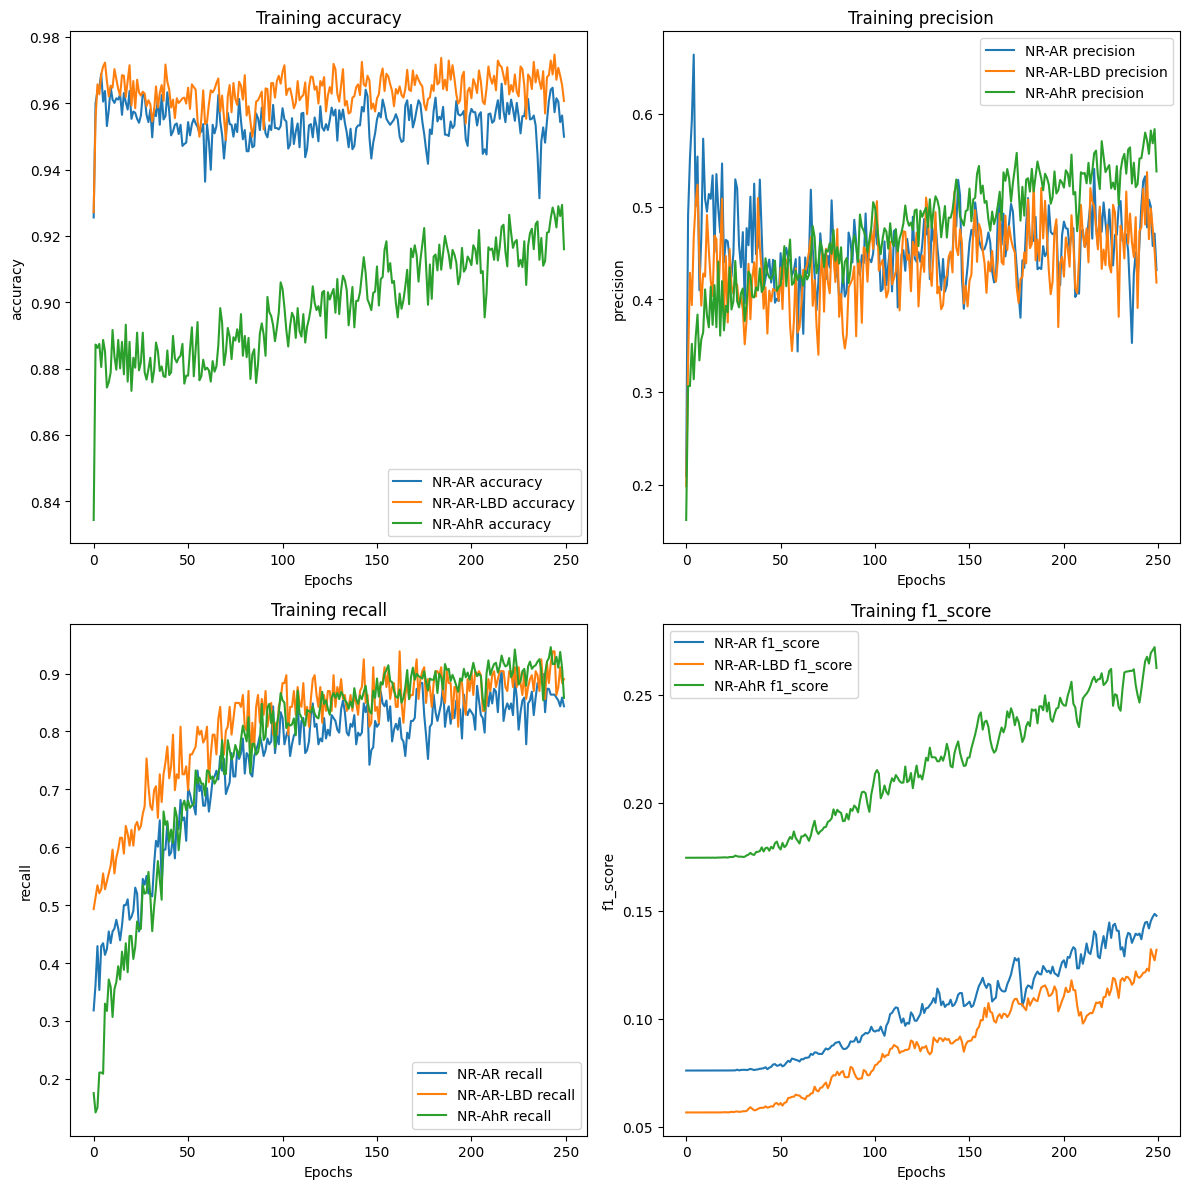

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['NR-AR_accuracy'], label='NR-AR accuracy')
plt.plot(history.history['NR-AR-LBD_accuracy'], label='NR-AR-LBD accuracy')
plt.plot(history.history['NR-AhR_accuracy'], label='NR-AhR accuracy')

plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(history.history['NR-AR_precision'], label='NR-AR precision')
plt.plot(history.history['NR-AR-LBD_precision'], label='NR-AR-LBD precision')
plt.plot(history.history['NR-AhR_precision'], label='NR-AhR precision')

plt.title('Training precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(history.history['NR-AR_recall'], label='NR-AR recall')
plt.plot(history.history['NR-AR-LBD_recall'], label='NR-AR-LBD recall')
plt.plot(history.history['NR-AhR_recall'], label='NR-AhR recall')

plt.title('Training recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(history.history['NR-AR_f1_score'], label='NR-AR f1_score')
plt.plot(history.history['NR-AR-LBD_f1_score'], label='NR-AR-LBD f1_score')
plt.plot(history.history['NR-AhR_f1_score'], label='NR-AhR f1_score')

plt.title('Training f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()


plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

In [ ]:
features_test = np.array(features_test)

NR_AR_array = np.array(task_test.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_test.iloc[:,1:2])
NR_AhR_array = np.array(task_test.iloc[:,2:3])

results = myModel.evaluate(features_test, [NR_AR_array, NR_AR_LBD_array, NR_AhR_array], verbose = 1)
results

# Calculate averages for each metric type
avg_accuracy = (results[4] + results[8] + results[12]) / 3
avg_f1_score = (results[5] + results[9] + results[13]) / 3
avg_precision = (results[6] + results[10] + results[14]) / 3
avg_recall = (results[7] + results[11] + results[15]) / 3

# Print the results with nice formatting
print("\nAverage Metrics Across All Three Tasks:")
print(f"Average Accuracy:  {avg_accuracy:.4f}")
print(f"Average F1-Score:  {avg_f1_score:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall:    {avg_recall:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - NR-AR-LBD_accuracy: 0.9499 - NR-AR-LBD_f1_score: 0.1157 - NR-AR-LBD_loss: 0.0059 - NR-AR-LBD_precision: 0.3444 - NR-AR-LBD_recall: 0.5467 - NR-AR_accuracy: 0.9467 - NR-AR_f1_score: 0.0949 - NR-AR_loss: 0.0083 - NR-AR_precision: 0.3179 - NR-AR_recall: 0.5545 - NR-AhR_accuracy: 0.8678 - NR-AhR_f1_score: 0.2453 - NR-AhR_loss: 0.0263 - NR-AhR_precision: 0.3494 - NR-AhR_recall: 0.3678 - loss: 0.0405

Average Metrics Across All Three Tasks:
Average Accuracy:  0.9238
Average F1-Score:  0.1615
Average Precision: 0.3644
Average Recall:    0.4829


# **Seven Tasks**

In [ ]:
TOX21_TASKS = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma']

In [ ]:
task_data = data.iloc[:, 0:7]
feature_data = data.iloc[:, 14:]

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_data)

from joblib import dump, load
dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
print(task_data.shape)
print(feature_data.shape)
#split the data into training and test data
features_train, features_test, task_train, task_test = train_test_split(scaled_data, task_data, test_size=0.20, random_state=42)

(7831, 7)
(7831, 384)


In [ ]:
def calculate_class_weights_for_columns(y_columns):
    class_weights_dict = {}

    for col_idx in range(y_columns.shape[1]):
        column = y_columns.iloc[:, col_idx]
        unique_classes, class_counts = np.unique(column, return_counts=True)
        total_samples = len(column)
        class_weights = {}

        for class_label, class_count in zip(unique_classes, class_counts):
            class_weight = total_samples / (2.0 * class_count)
            class_weights[class_label] = class_weight

        class_weights_dict[col_idx] = class_weights

    return class_weights_dict

class_weights = calculate_class_weights_for_columns(task_train)
print("Class weights per column:", class_weights)

Class weights per column: {0: {0: 0.5206117021276596, 1: 12.629032258064516}, 1: {0: 0.5160652496292635, 1: 16.06153846153846}, 2: {0: 0.5530637471304962, 1: 5.211314475873544}, 3: {0: 0.5211314475873544, 1: 12.330708661417322}, 4: {0: 0.5569980437488885, 1: 4.886115444617785}, 5: {0: 0.5233957219251337, 1: 11.185714285714285}, 6: {0: 0.5131902343109946, 1: 19.453416149068325}}


In [ ]:
sample_weights = []
for index, task in enumerate(task_train):
  cw_dict = class_weights[index]
  off_cw = cw_dict[0]
  on_cw = cw_dict[1]

  # print(off_cw, on_cw)
  task_weight = []
  # print(task)
  for x, item in enumerate(task_train[task]):
    if item == 0:
      task_weight.append(off_cw)
    if item == 1:
      task_weight.append(on_cw)

  sample_weights.append(task_weight)

print(sample_weights)
print(len(sample_weights)) # = np.array(sample_weight).T
print(len(sample_weights[0]), len(sample_weights[1]), len(sample_weights[2]))

[[0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 12.629032258064516, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596, 0.5206117021276596

In [ ]:
features_train = np.array(features_train)

NR_AR_array = np.array(task_train.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_train.iloc[:,1:2])
NR_AhR_array = np.array(task_train.iloc[:,2:3])
NR_Aromatase_array = np.array(task_train.iloc[:,3:4])
NR_ER_array = np.array(task_train.iloc[:,4:5])
NR_ER_LBD_array = np.array(task_train.iloc[:,5:6])
NR_PPAR_gamma_array = np.array(task_train.iloc[:,6:7])

In [ ]:
NR_AR_weights = np.array(sample_weights[0])
NR_AR_LBD_weights = np.array(sample_weights[1])
NR_AhR_weights = np.array(sample_weights[2])
NR_Aromatase_weights = np.array(sample_weights[3])
NR_ER_weights = np.array(sample_weights[4])
NR_ER_LBD_weights = np.array(sample_weights[5])
NR_PPAR_gamma_weights = np.array(sample_weights[6])

In [ ]:
# from tensorflow.keras.initializers import Constant

def build_model(features):
  #input layer
  xin = tf.keras.layers.Input((features.shape[1],))

  # Add a normalizer layer and adapt it outside the function
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(features) # Adapt using the input 'features'

  xin = normalizer(xin)

  #hidden layers
  x1 = tf.keras.layers.Dense(64, activation='relu')(xin)
  x1 = tf.keras.layers.Dropout(0.42)(x1)
  x2 = tf.keras.layers.Dense(32, activation='relu')(x1)
  x2 = tf.keras.layers.Dropout(0.42)(x2)

  outputs = list()
  for _task in TOX21_TASKS:
    outputs.append(tf.keras.layers.Dense(1, activation='sigmoid', name=_task)(x2))

  return tf.keras.models.Model(inputs = xin, outputs = outputs)

In [ ]:
myModel = build_model(features_train)


myModel.compile(loss = [focal_loss(alpha=0.25, gamma=2.0)]*len(TOX21_TASKS),
                metrics=[["accuracy", "precision", "f1_score", "recall"]]*len(TOX21_TASKS),
                optimizer=Adam(learning_rate=0.007))

myModel.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_27CLONE      │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │         24,640 │ keras_tensor_27CLONE[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_5[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_5[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 32)             │              0 │ dense_6[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR (Dense)             │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AR-LBD (Dense)         │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-AhR (Dense)            │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-Aromatase (Dense)      │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-ER (Dense)             │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-ER-LBD (Dense)         │ (None, 1)              │             33 │ dropout_6[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ NR-PPAR-gamma (Dense)     │ (None, 1)              │             33 │ dropout_6[1][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,951 (105.28 KB)

 Trainable params: 26,951 (105.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = myModel.fit(features_train,
                    [NR_AR_array, NR_AR_LBD_array, NR_AhR_array, NR_Aromatase_array, NR_ER_array, NR_ER_LBD_array, NR_PPAR_gamma_array],
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2,
                    sample_weight = [NR_AR_weights, NR_AR_LBD_weights, NR_AhR_weights, NR_Aromatase_weights, NR_ER_weights, NR_ER_LBD_weights, NR_PPAR_gamma_weights])

Epoch 1/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - NR-AR-LBD_accuracy: 0.9230 - NR-AR-LBD_f1_score: 0.0579 - NR-AR-LBD_loss: 0.0228 - NR-AR-LBD_precision: 0.1408 - NR-AR-LBD_recall: 0.2195 - NR-AR_accuracy: 0.8806 - NR-AR_f1_score: 0.0799 - NR-AR_loss: 0.0386 - NR-AR_precision: 0.1119 - NR-AR_recall: 0.2498 - NR-AhR_accuracy: 0.8128 - NR-AhR_f1_score: 0.1647 - NR-AhR_loss: 0.0395 - NR-AhR_precision: 0.1146 - NR-AhR_recall: 0.1498 - NR-Aromatase_accuracy: 0.8050 - NR-Aromatase_f1_score: 0.0755 - NR-Aromatase_loss: 0.0472 - NR-Aromatase_precision: 0.0539 - NR-Aromatase_recall: 0.2165 - NR-ER-LBD_accuracy: 0.8933 - NR-ER-LBD_f1_score: 0.0715 - NR-ER-LBD_loss: 0.0296 - NR-ER-LBD_precision: 0.0458 - NR-ER-LBD_recall: 0.0837 - NR-ER_accuracy: 0.7060 - NR-ER_f1_score: 0.1675 - NR-ER_loss: 0.0645 - NR-ER_precision: 0.1055 - NR-ER_recall: 0.2758 - NR-PPAR-gamma_accuracy: 0.8583 - NR-PPAR-gamma_f1_score: 0.0491 - NR-PPAR-gamma_loss: 0.0436 - NR-PPAR-gamma_precision: 0.0179 - NR-PPAR-gamma_

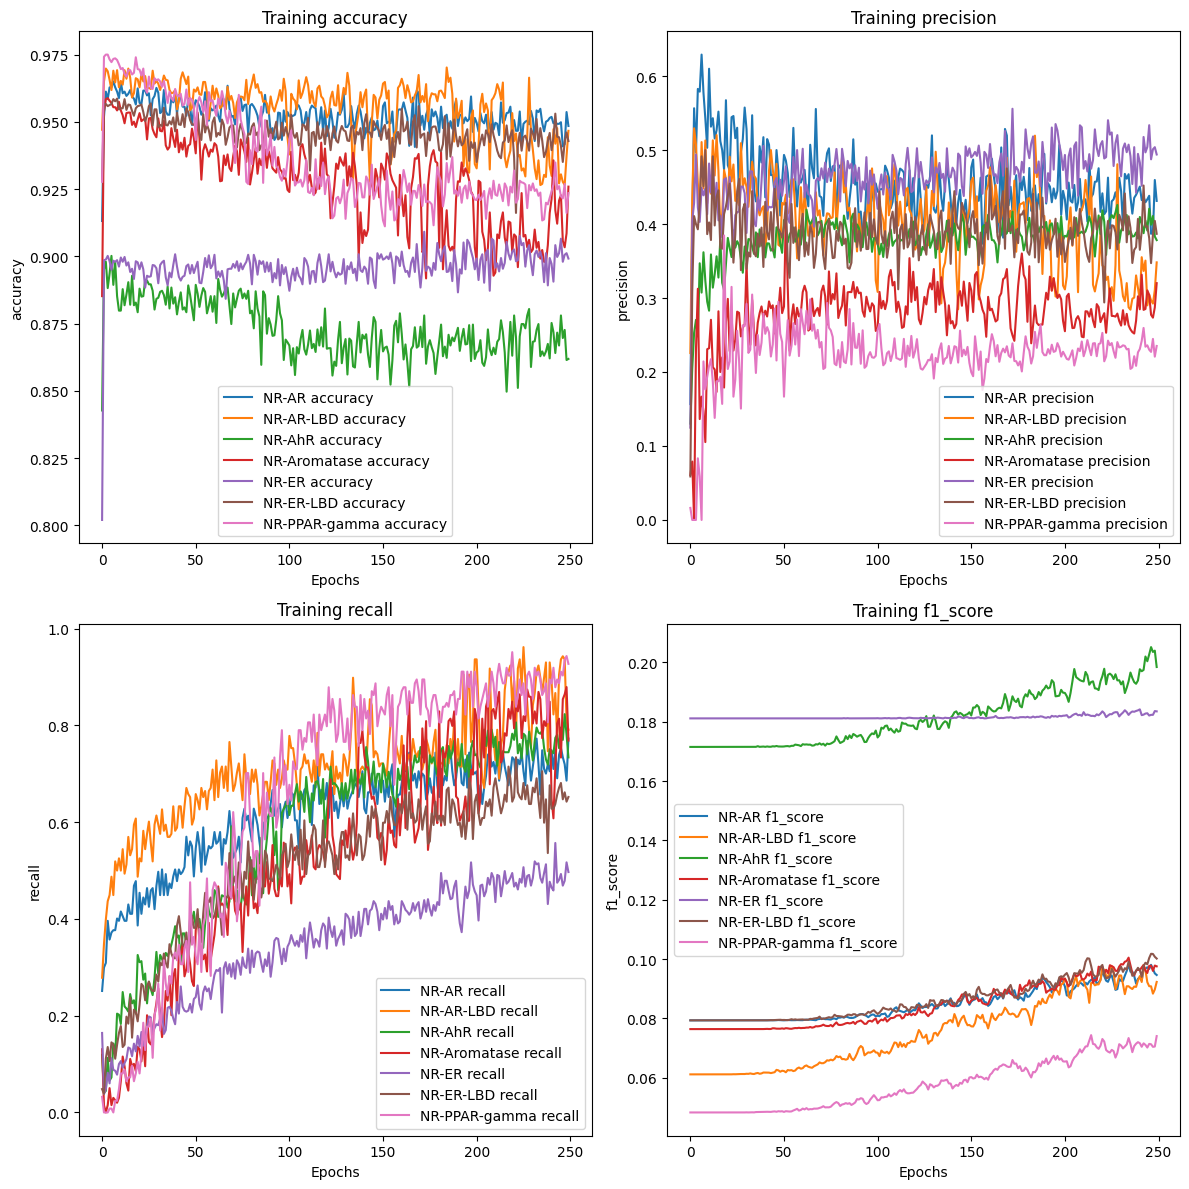

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['NR-AR_accuracy'], label='NR-AR accuracy')
plt.plot(history.history['NR-AR-LBD_accuracy'], label='NR-AR-LBD accuracy')
plt.plot(history.history['NR-AhR_accuracy'], label='NR-AhR accuracy')

plt.plot(history.history['NR-Aromatase_accuracy'], label='NR-Aromatase accuracy')
plt.plot(history.history['NR-ER_accuracy'], label='NR-ER accuracy')
plt.plot(history.history['NR-ER-LBD_accuracy'], label='NR-ER-LBD accuracy')
plt.plot(history.history['NR-PPAR-gamma_accuracy'], label='NR-PPAR-gamma accuracy')

plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(history.history['NR-AR_precision'], label='NR-AR precision')
plt.plot(history.history['NR-AR-LBD_precision'], label='NR-AR-LBD precision')
plt.plot(history.history['NR-AhR_precision'], label='NR-AhR precision')

plt.plot(history.history['NR-Aromatase_precision'], label='NR-Aromatase precision')
plt.plot(history.history['NR-ER_precision'], label='NR-ER precision')
plt.plot(history.history['NR-ER-LBD_precision'], label='NR-ER-LBD precision')
plt.plot(history.history['NR-PPAR-gamma_precision'], label='NR-PPAR-gamma precision')

plt.title('Training precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(history.history['NR-AR_recall'], label='NR-AR recall')
plt.plot(history.history['NR-AR-LBD_recall'], label='NR-AR-LBD recall')
plt.plot(history.history['NR-AhR_recall'], label='NR-AhR recall')

plt.plot(history.history['NR-Aromatase_recall'], label='NR-Aromatase recall')
plt.plot(history.history['NR-ER_recall'], label='NR-ER recall')
plt.plot(history.history['NR-ER-LBD_recall'], label='NR-ER-LBD recall')
plt.plot(history.history['NR-PPAR-gamma_recall'], label='NR-PPAR-gamma recall')

plt.title('Training recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(history.history['NR-AR_f1_score'], label='NR-AR f1_score')
plt.plot(history.history['NR-AR-LBD_f1_score'], label='NR-AR-LBD f1_score')
plt.plot(history.history['NR-AhR_f1_score'], label='NR-AhR f1_score')

plt.plot(history.history['NR-Aromatase_f1_score'], label='NR-Aromatase f1_score')
plt.plot(history.history['NR-ER_f1_score'], label='NR-ER f1_score')
plt.plot(history.history['NR-ER-LBD_f1_score'], label='NR-ER-LBD f1_score')
plt.plot(history.history['NR-PPAR-gamma_f1_score'], label='NR-PPAR-gamma f1_score')

plt.title('Training f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()


plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

In [ ]:
features_test = np.array(features_test)

NR_AR_array = np.array(task_test.iloc[:, 0:1])
NR_AR_LBD_array = np.array(task_test.iloc[:,1:2])
NR_AhR_array = np.array(task_test.iloc[:,2:3])

NR_Aromatase_array = np.array(task_test.iloc[:,3:4])
NR_ER_array = np.array(task_test.iloc[:,4:5])
NR_ER_LBD_array = np.array(task_test.iloc[:,5:6])
NR_PPAR_gamma_array = np.array(task_test.iloc[:,6:7])

results = myModel.evaluate(features_test, [NR_AR_array, NR_AR_LBD_array, NR_AhR_array, NR_Aromatase_array, NR_ER_array, NR_ER_LBD_array, NR_PPAR_gamma_array], verbose = 1)
results



offset = 4
# Calculate averages for each metric type


avg_accuracy = 0
avg_f1_score = 0
avg_precision = 0
avg_recall = 0

offset = 8
for x in range(offset, len(results), 4):
  avg_accuracy += results[x]
  avg_f1_score += results[x+1]
  avg_precision += results[x+2]
  avg_recall += results[x+3]


avg_accuracy /= 7
avg_f1_score /= 7
avg_precision /= 7
avg_recall /= 7

# Print the results with nice formatting
print("\nAverage Metrics Across All Three Tasks:")
print(f"Average Accuracy:  {avg_accuracy:.4f}")
print(f"Average F1-Score:  {avg_f1_score:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall:    {avg_recall:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - NR-AR-LBD_accuracy: 0.9750 - NR-AR-LBD_f1_score: 0.0677 - NR-AR-LBD_loss: 0.0031 - NR-AR-LBD_precision: 0.5393 - NR-AR-LBD_recall: 0.4718 - NR-AR_accuracy: 0.9465 - NR-AR_f1_score: 0.0929 - NR-AR_loss: 0.0053 - NR-AR_precision: 0.3741 - NR-AR_recall: 0.3844 - NR-AhR_accuracy: 0.8703 - NR-AhR_f1_score: 0.2161 - NR-AhR_loss: 0.0163 - NR-AhR_precision: 0.4069 - NR-AhR_recall: 0.4727 - NR-Aromatase_accuracy: 0.9273 - NR-Aromatase_f1_score: 0.0704 - NR-Aromatase_loss: 0.0060 - NR-Aromatase_precision: 0.0870 - NR-Aromatase_recall: 0.1454 - NR-ER-LBD_accuracy: 0.9491 - NR-ER-LBD_f1_score: 0.1144 - NR-ER-LBD_loss: 0.0089 - NR-ER-LBD_precision: 0.5267 - NR-ER-LBD_recall: 0.3131 - NR-ER_accuracy: 0.8808 - NR-ER_f1_score: 0.1816 - NR-ER_loss: 0.0138 - NR-ER_precision: 0.3686 - NR-ER_recall: 0.2709 - NR-PPAR-gamma_accuracy: 0.9632 - NR-PPAR-gamma_f1_score: 0.0484 - NR-PPAR-gamma_loss: 0.0021 - NR-PPAR-gamma_precision: 0.1360 - NR-PPAR-gamma_recall: 0.2150 -

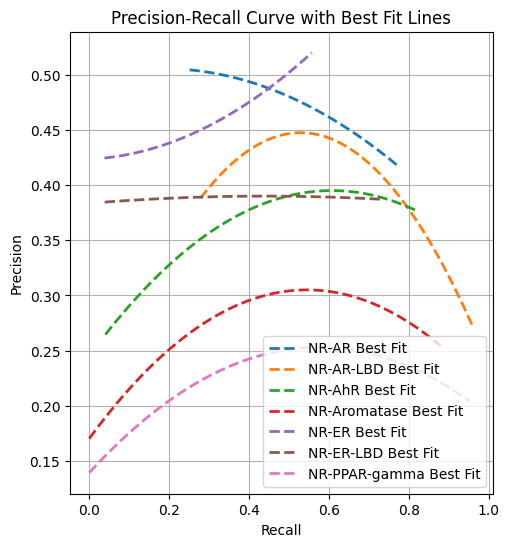

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.figure(figsize=(12, 6))

# Define a quadratic function for curve fitting
def poly_fit(x, a, b, c):
    return a * x**2 + b * x + c

# Precision-Recall plot
plt.subplot(1, 2, 1)
for task in ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma']:
    recall = np.array(history.history[f'{task}_recall'])
    precision = np.array(history.history[f'{task}_precision'])

    # Scatter plot of actual points
    # plt.scatter(recall, precision, marker='o', alpha=0.5, label=f'{task} Data')

    # Fit a curve and plot a smooth line
    if len(recall) > 2:  # Ensure enough points for fitting
        params, _ = curve_fit(poly_fit, recall, precision)
        recall_smooth = np.linspace(recall.min(), recall.max(), 100)
        precision_smooth = poly_fit(recall_smooth, *params)
        plt.plot(recall_smooth, precision_smooth, linestyle='--', linewidth=2, label=f'{task} Best Fit')

plt.title('Precision-Recall Curve with Best Fit Lines')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()

plt.show()


# **12 tasks**

In [ ]:
TOX21_TASKS = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma']